# Multi-Disease Prediction System
Datasets:
  - Kidney Disease
  - Liver Disease
  - Parkinson's Disease
Steps:
1. Load datasets
2. Clean & preprocess (handle missing values, encode categorical vars, scale, handle outliers)
3. Handle imbalance with SMOTE
4. Show feature correlations / importance
5. Train/Test split
6. Train ML models (LR, RF, DT, SVM, KNN) with overfitting reduction
7. Evaluate with Accuracy, AUC, Classification Report
8. Hyperparameter Tuning for all models





#  IMPORT LIBRARIES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from imblearn.over_sampling import SMOTE

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

#  LOAD DATASETS

In [2]:

kidney_dis = pd.read_excel("kidney_disease.xlsx")
liver_dis = pd.read_excel("indian_liver_patient.xlsx")
parkinson_dis = pd.read_excel("parkinsons.xlsx")

print("Kidney dataset shape:", kidney_dis.shape)
print("Liver dataset shape:", liver_dis.shape)
print("Parkinson dataset shape:", parkinson_dis.shape)

# Check general info
print("\n===== Kidney Dataset Info =====")
print(kidney_dis.info())

print("\n===== Liver Dataset Info =====")
print(liver_dis.info())

print("\n===== Parkinson Dataset Info =====")
print(parkinson_dis.info())

# Column names
print("\nKidney columns:\n", kidney_dis.columns.tolist())
print("\nLiver columns:\n", liver_dis.columns.tolist())
print("\nParkinson columns:\n", parkinson_dis.columns.tolist())

# Descriptive statistics
print("\n===== Kidney Dataset Describe =====")
print(kidney_dis.describe())

print("\n===== Liver Dataset Describe =====")
print(liver_dis.describe())

print("\n===== Parkinson Dataset Describe =====")
print(parkinson_dis.describe())

Kidney dataset shape: (400, 26)
Liver dataset shape: (583, 11)
Parkinson dataset shape: (195, 24)

===== Kidney Dataset Info =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64

#  DATA CLEANING AND PREPROCESSING

In [3]:

# ============================
# 🔹 Helper Function — Missing Summary
# ============================
def missing_summary(df, name):
    total = df.isnull().sum()
    percent = (total / len(df)) * 100
    summary = pd.DataFrame({
        'Missing Count': total,
        'Missing %': percent.round(2)
    })
    print(f"\n===== Missing Value Summary: {name} =====")
    print(summary[summary['Missing Count'] > 0] if summary['Missing Count'].sum() > 0 else " No missing values found!")

# Check missing values for each dataset
missing_summary(kidney_dis, "Kidney Dataset")
missing_summary(liver_dis, "Liver Dataset")
missing_summary(parkinson_dis, "Parkinson Dataset")

# ============================
# 🔹 LIVER DATA PREPROCESSING
# ============================
def preprocess_liver(data):
    # If a path is passed, load the file
    df = pd.read_excel(data) if isinstance(data, str) else data.copy()

    df["Albumin_and_Globulin_Ratio"].fillna(df["Albumin_and_Globulin_Ratio"].median(), inplace=True)
    le = LabelEncoder()
    df['Gender'] = le.fit_transform(df['Gender'])
    df['Dataset'] = df['Dataset'].map({1: 1, 2: 0})

    X = df.drop(columns=['Dataset'])
    y = df['Dataset']
    return X, y

# ============================
# 🔹 KIDNEY DATA PREPROCESSING
# ============================
def preprocess_kidney(data):
    df = pd.read_csv(data) if isinstance(data, str) else data.copy()

    if 'id' in df.columns:
        df = df.drop(columns=['id'])

    num_cols = ['age','bp','sg','al','su','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')

    imputer_num = SimpleImputer(strategy='median')
    df[num_cols] = imputer_num.fit_transform(df[num_cols])

    cat_cols = ['rbc','pc','pcc','ba','htn','dm','cad','appet','pe','ane']
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

    for i in cat_cols:
        print(f"{i} → {kidney_dis[i].unique()}")


    le = LabelEncoder()
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])

    df['classification'] = df['classification'].map({'ckd': 1, 'notckd': 0})

    X = df.drop(columns=['classification'])
    y = df['classification']
    return X, y


# ============================
# 🔹 PARKINSON DATA PREPROCESSING
# ============================
def preprocess_parkinson(data):
    df = pd.read_csv(data) if isinstance(data, str) else data.copy()

    if 'name' in df.columns:
        df = df.drop(columns=['name'])

    X = df.drop(columns=['status'])
    y = df['status']
    return X, y



kidney_X, kidney_y = preprocess_kidney(kidney_dis)
liver_X, liver_y = preprocess_liver(liver_dis)
parkinson_X, parkinson_y = preprocess_parkinson(parkinson_dis)

# ============================
# 🔹 Missing Value Summary
# ============================
missing_summary(liver_X, "Liver Dataset (Features)")
missing_summary(kidney_X, "Kidney Dataset (Features)")
missing_summary(parkinson_X, "Parkinson Dataset (Features)")


===== Missing Value Summary: Kidney Dataset =====
       Missing Count  Missing %
age                9       2.25
bp                12       3.00
sg                47      11.75
al                46      11.50
su                49      12.25
rbc              152      38.00
pc                65      16.25
pcc                4       1.00
ba                 4       1.00
bgr               44      11.00
bu                19       4.75
sc                17       4.25
sod               87      21.75
pot               88      22.00
hemo              52      13.00
pcv               70      17.50
wc               105      26.25
rc               130      32.50
htn                2       0.50
dm                 2       0.50
cad                2       0.50
appet              1       0.25
pe                 1       0.25
ane                1       0.25

===== Missing Value Summary: Liver Dataset =====
                            Missing Count  Missing %
Albumin_and_Globulin_Ratio              4     

C:\Users\rajul\AppData\Local\Temp\ipykernel_19932\4020787344.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Albumin_and_Globulin_Ratio"].fillna(df["Albumin_and_Globulin_Ratio"].median(), inplace=True)


#  EDA - EXPLORATORY DATA ANALYSIS

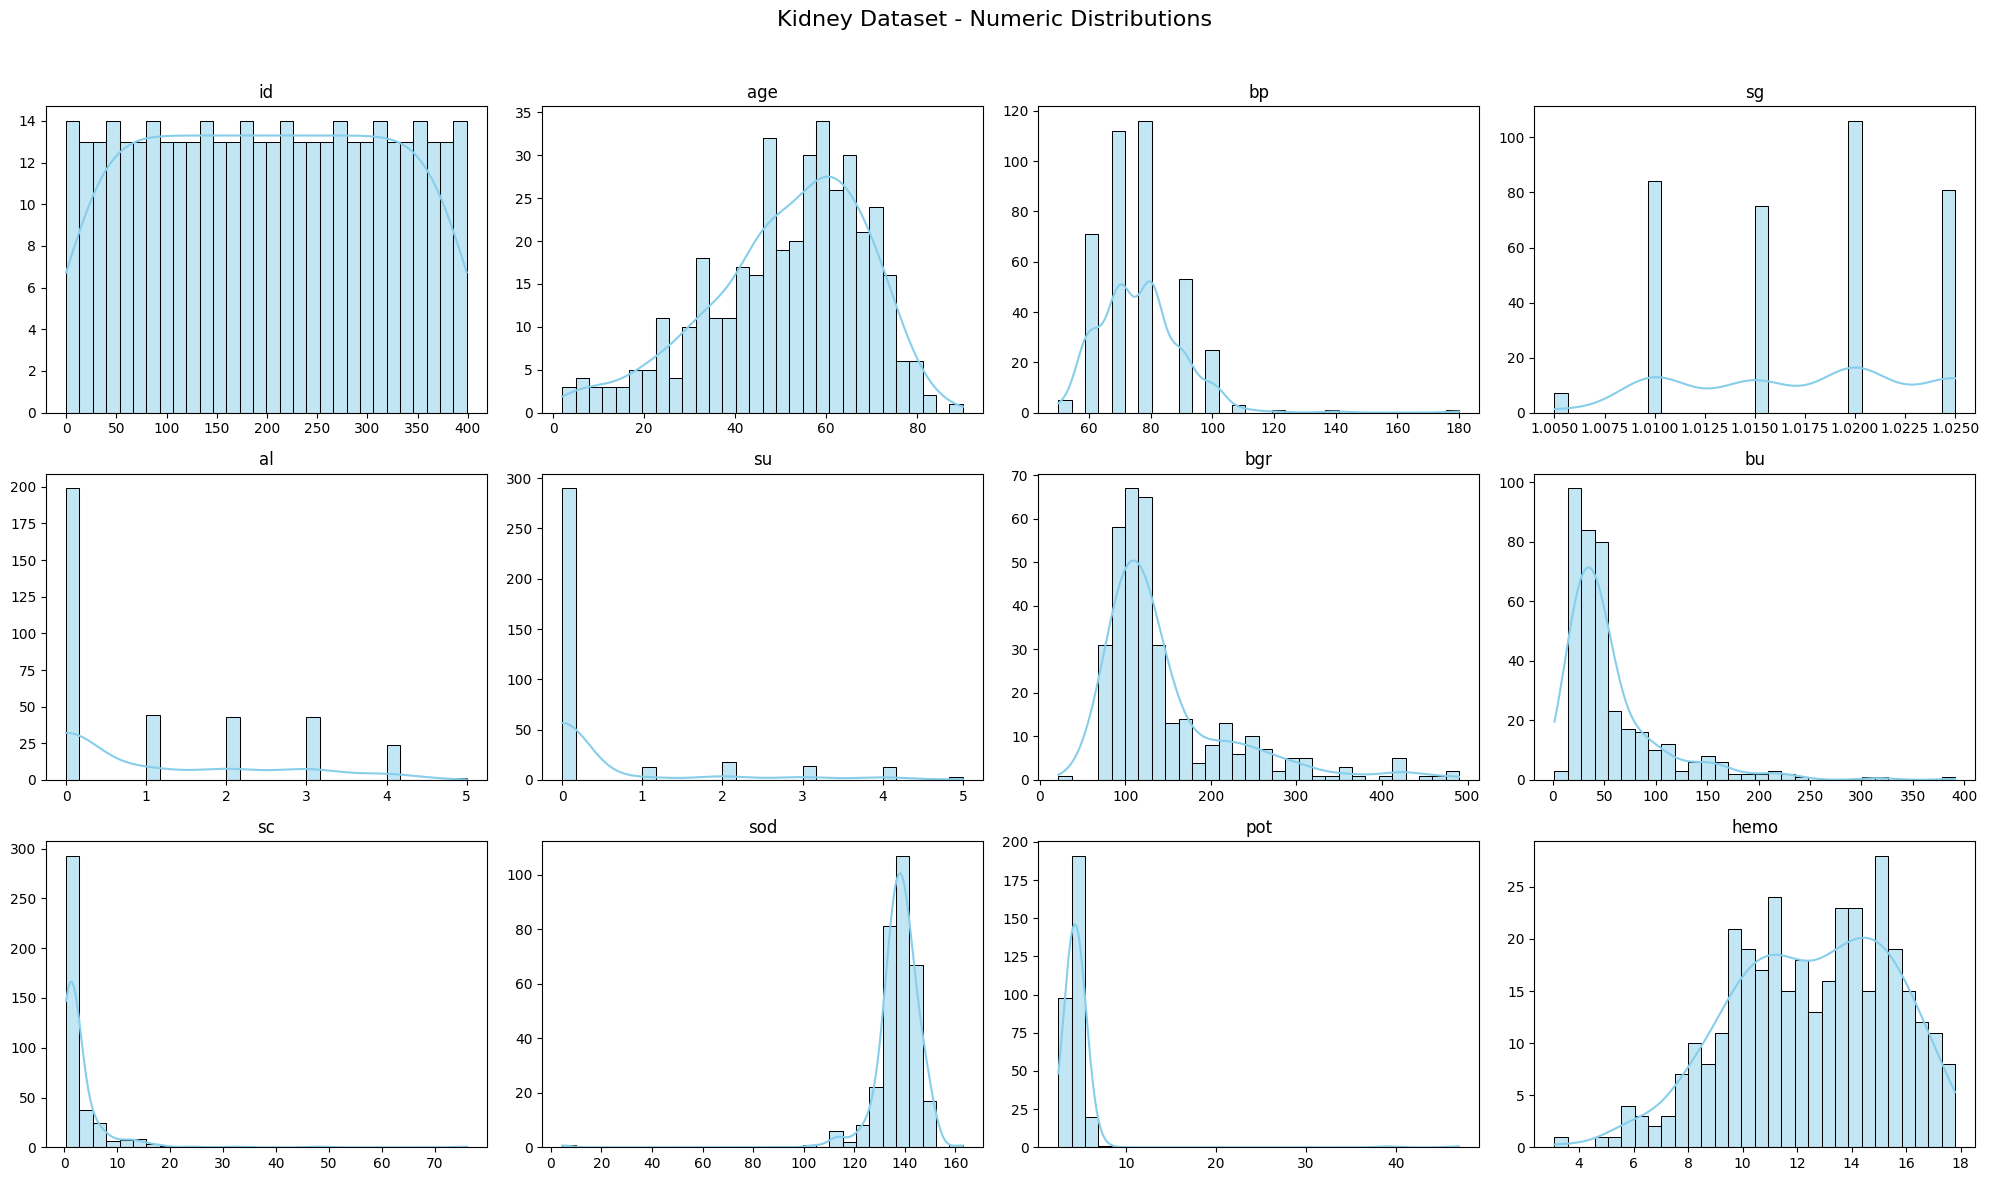

In [4]:
def plot_numeric_distributions(df, title, cols_per_row=4):
    """
    Plot histogram distribution for all numeric columns in a dataframe
    in a grid layout with `cols_per_row` subplots per row.
    """
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    n_cols = cols_per_row
    n_rows = (len(num_cols) + n_cols - 1) // n_cols  # ceil division

    plt.figure(figsize=(5*n_cols, 4*n_rows))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[col], kde=True, bins=30, color='skyblue')
        plt.title(col)
        plt.xlabel('')
        plt.ylabel('')

    plt.suptitle(f"{title} - Numeric Distributions", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()



# ---- Apply to all datasets ----
plot_numeric_distributions(kidney_dis, "Kidney Dataset")

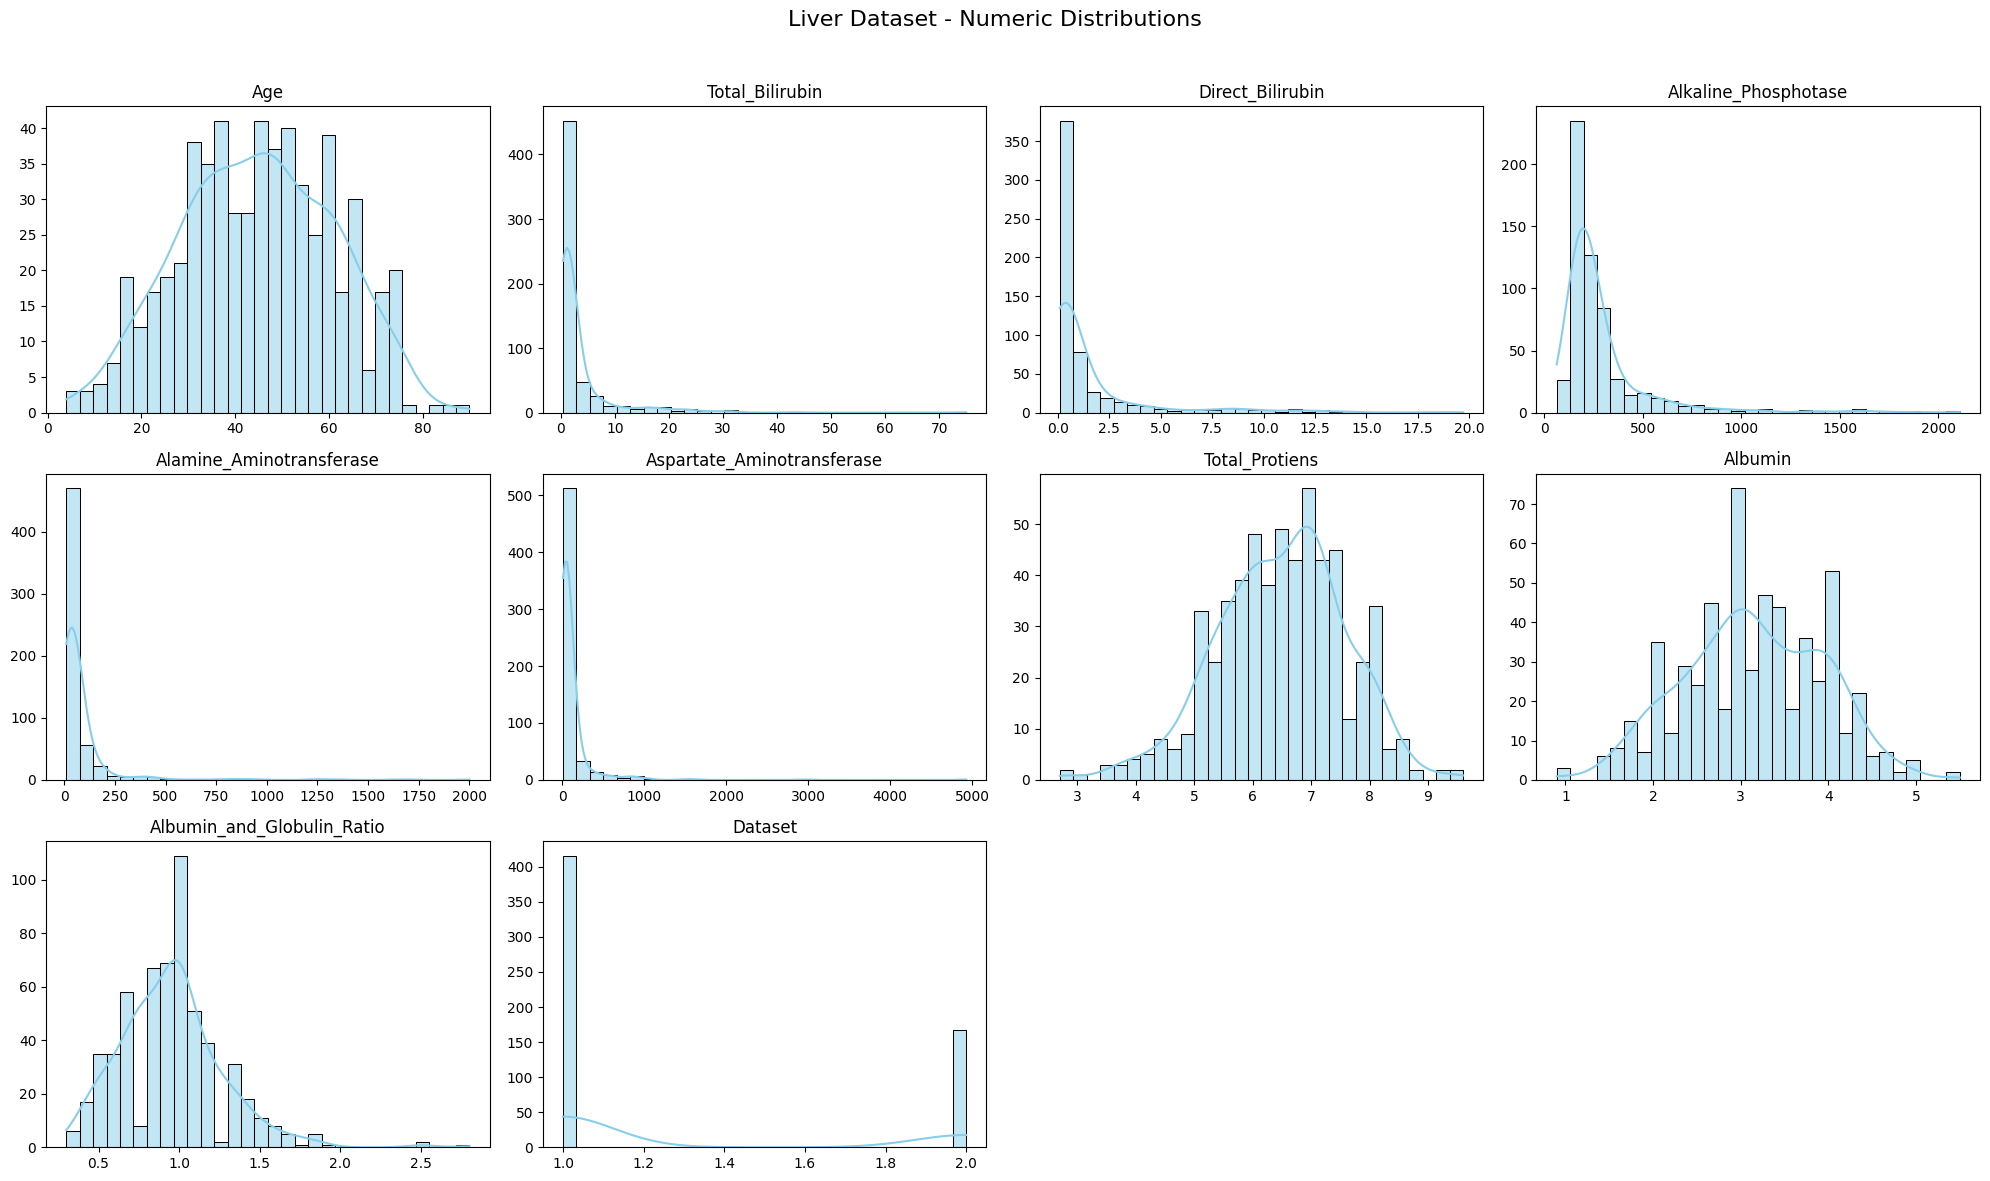

In [5]:

plot_numeric_distributions(liver_dis, "Liver Dataset")

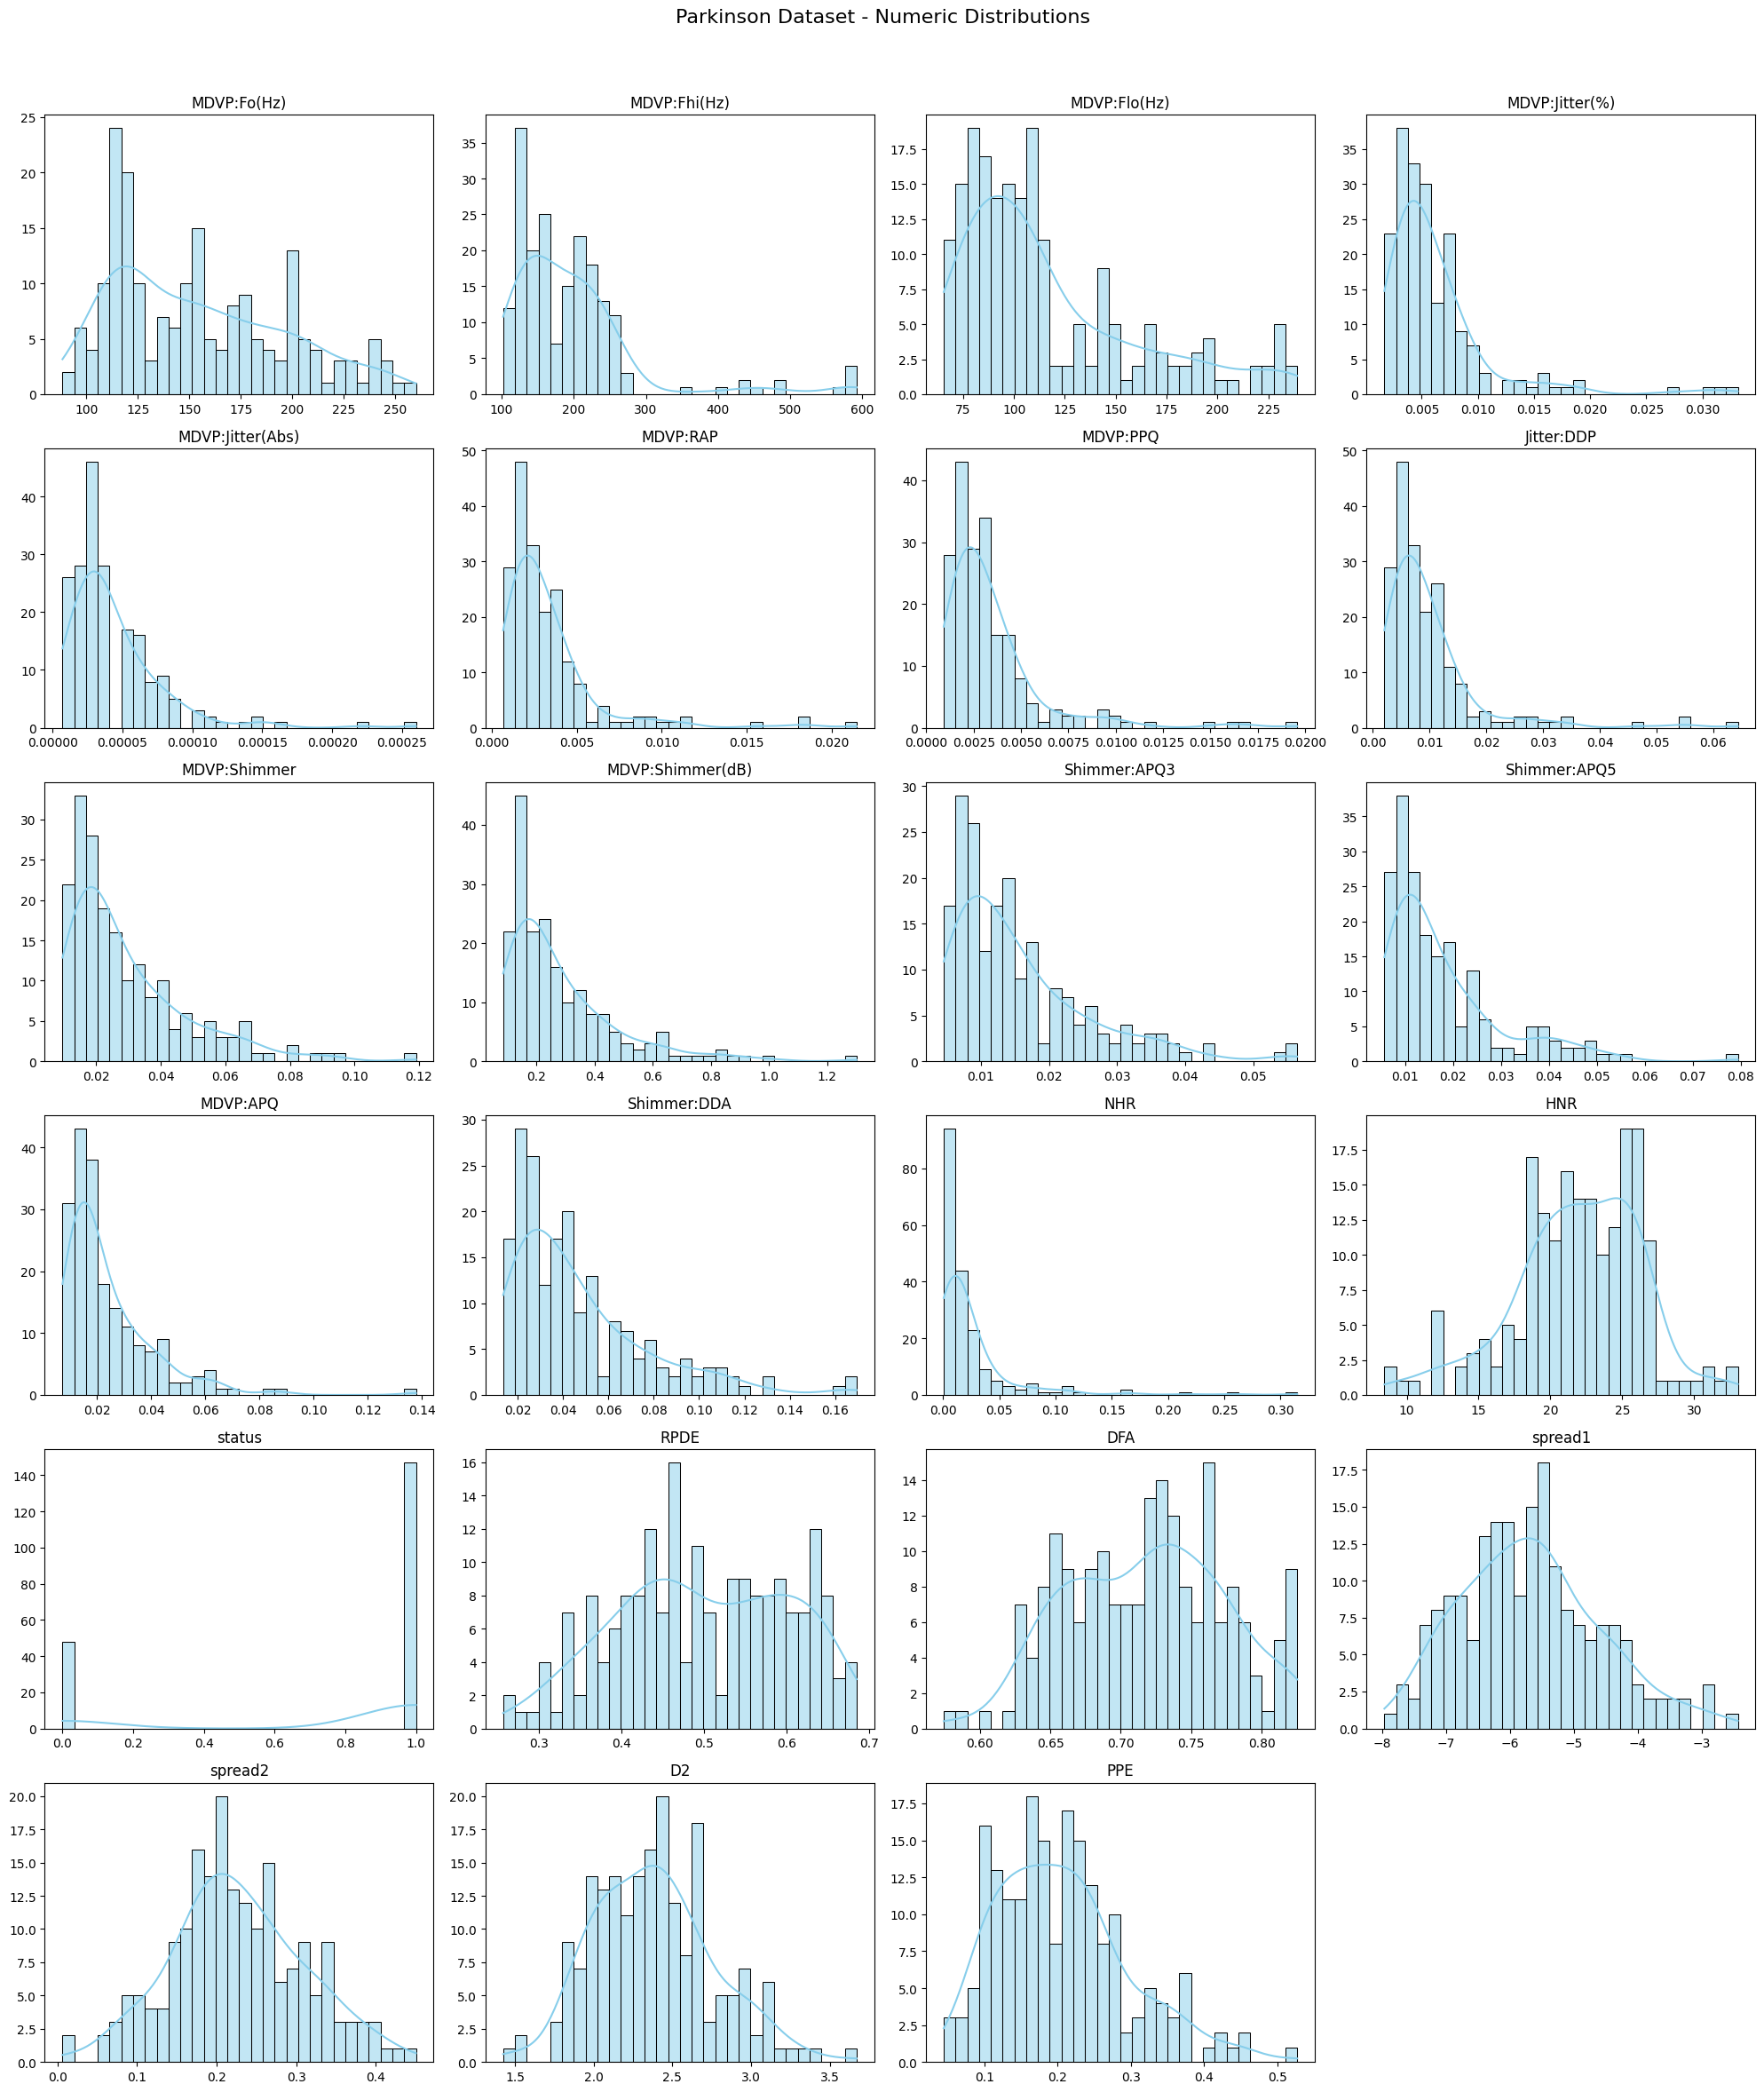

In [6]:

plot_numeric_distributions(parkinson_dis, "Parkinson Dataset")


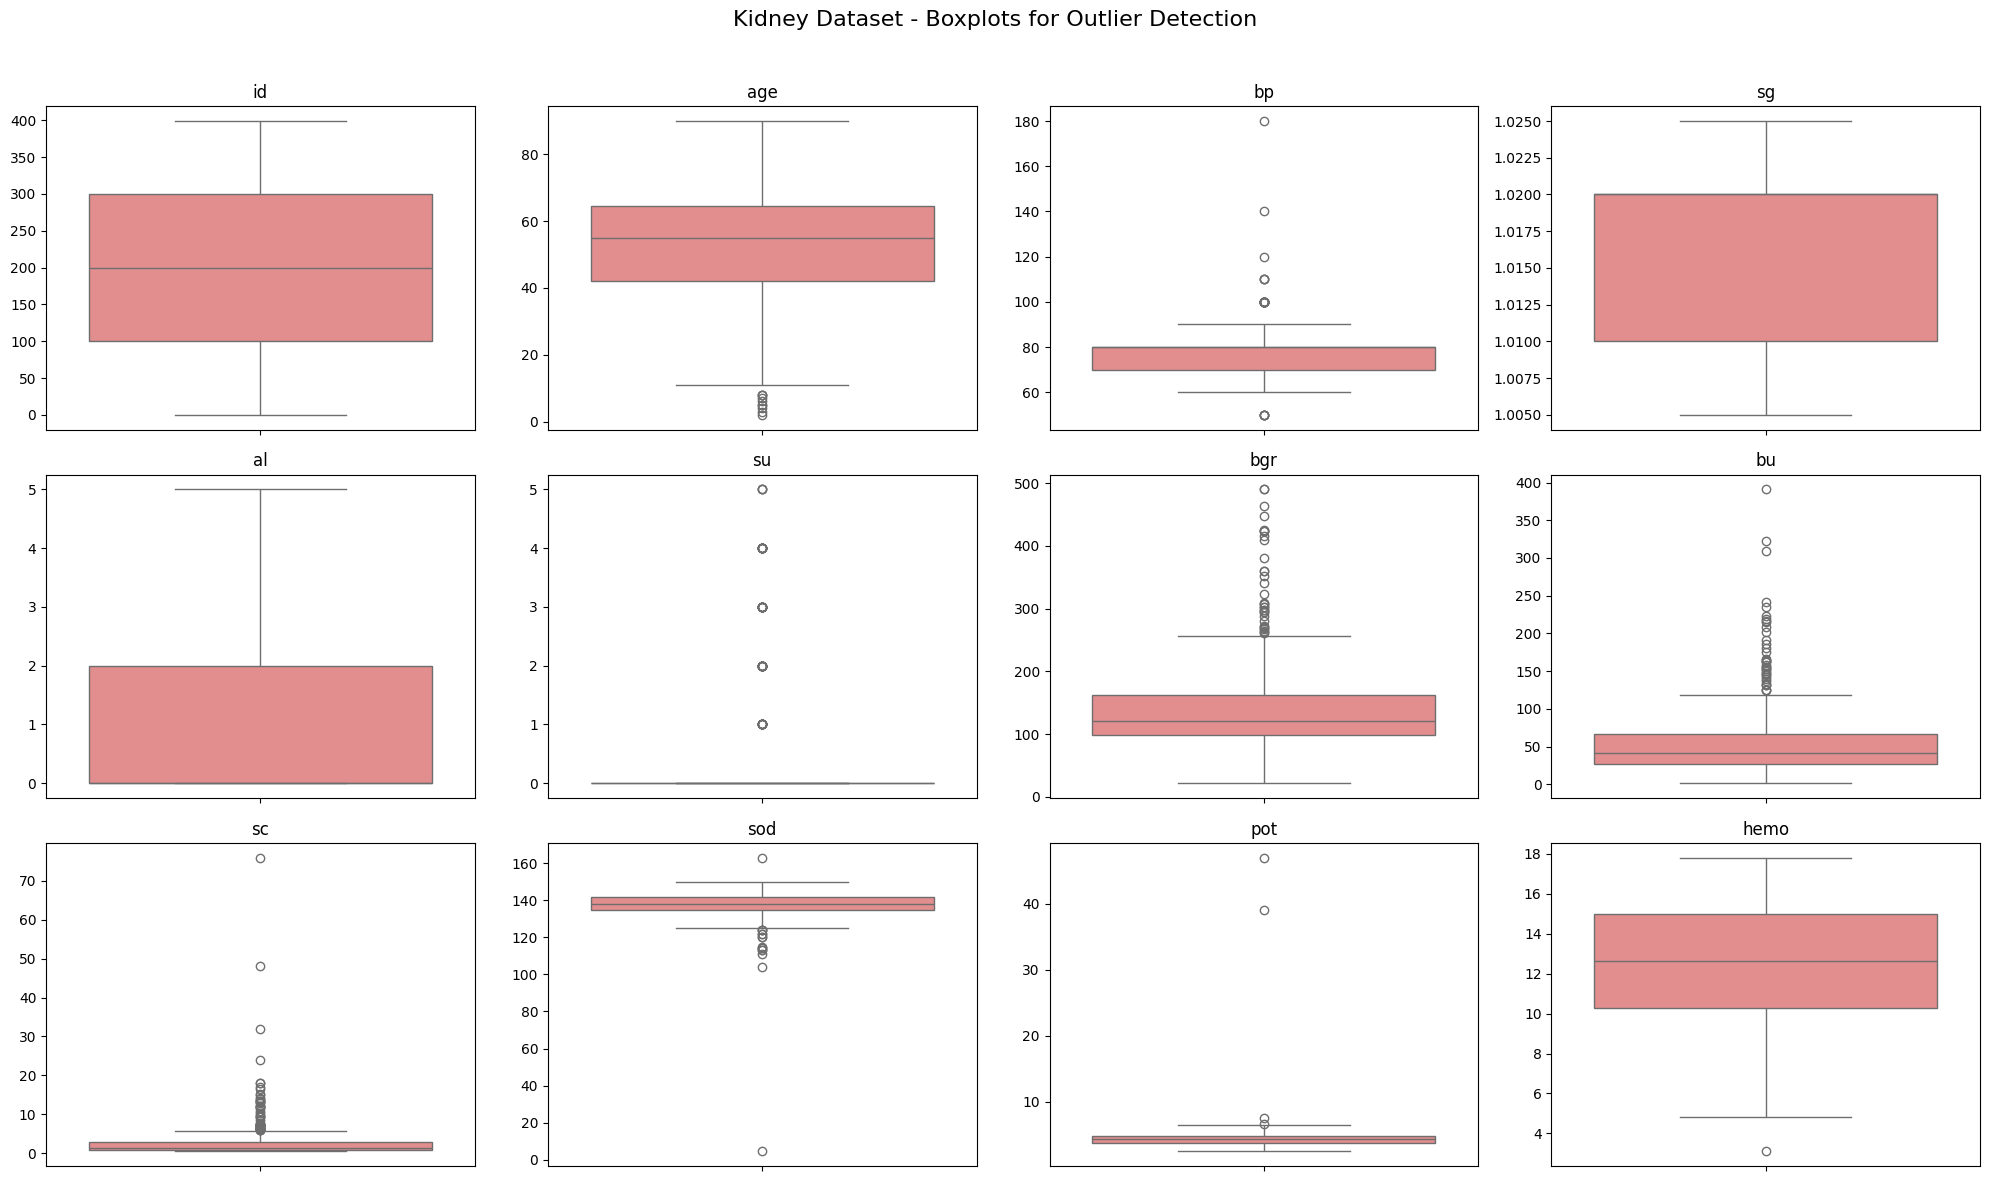

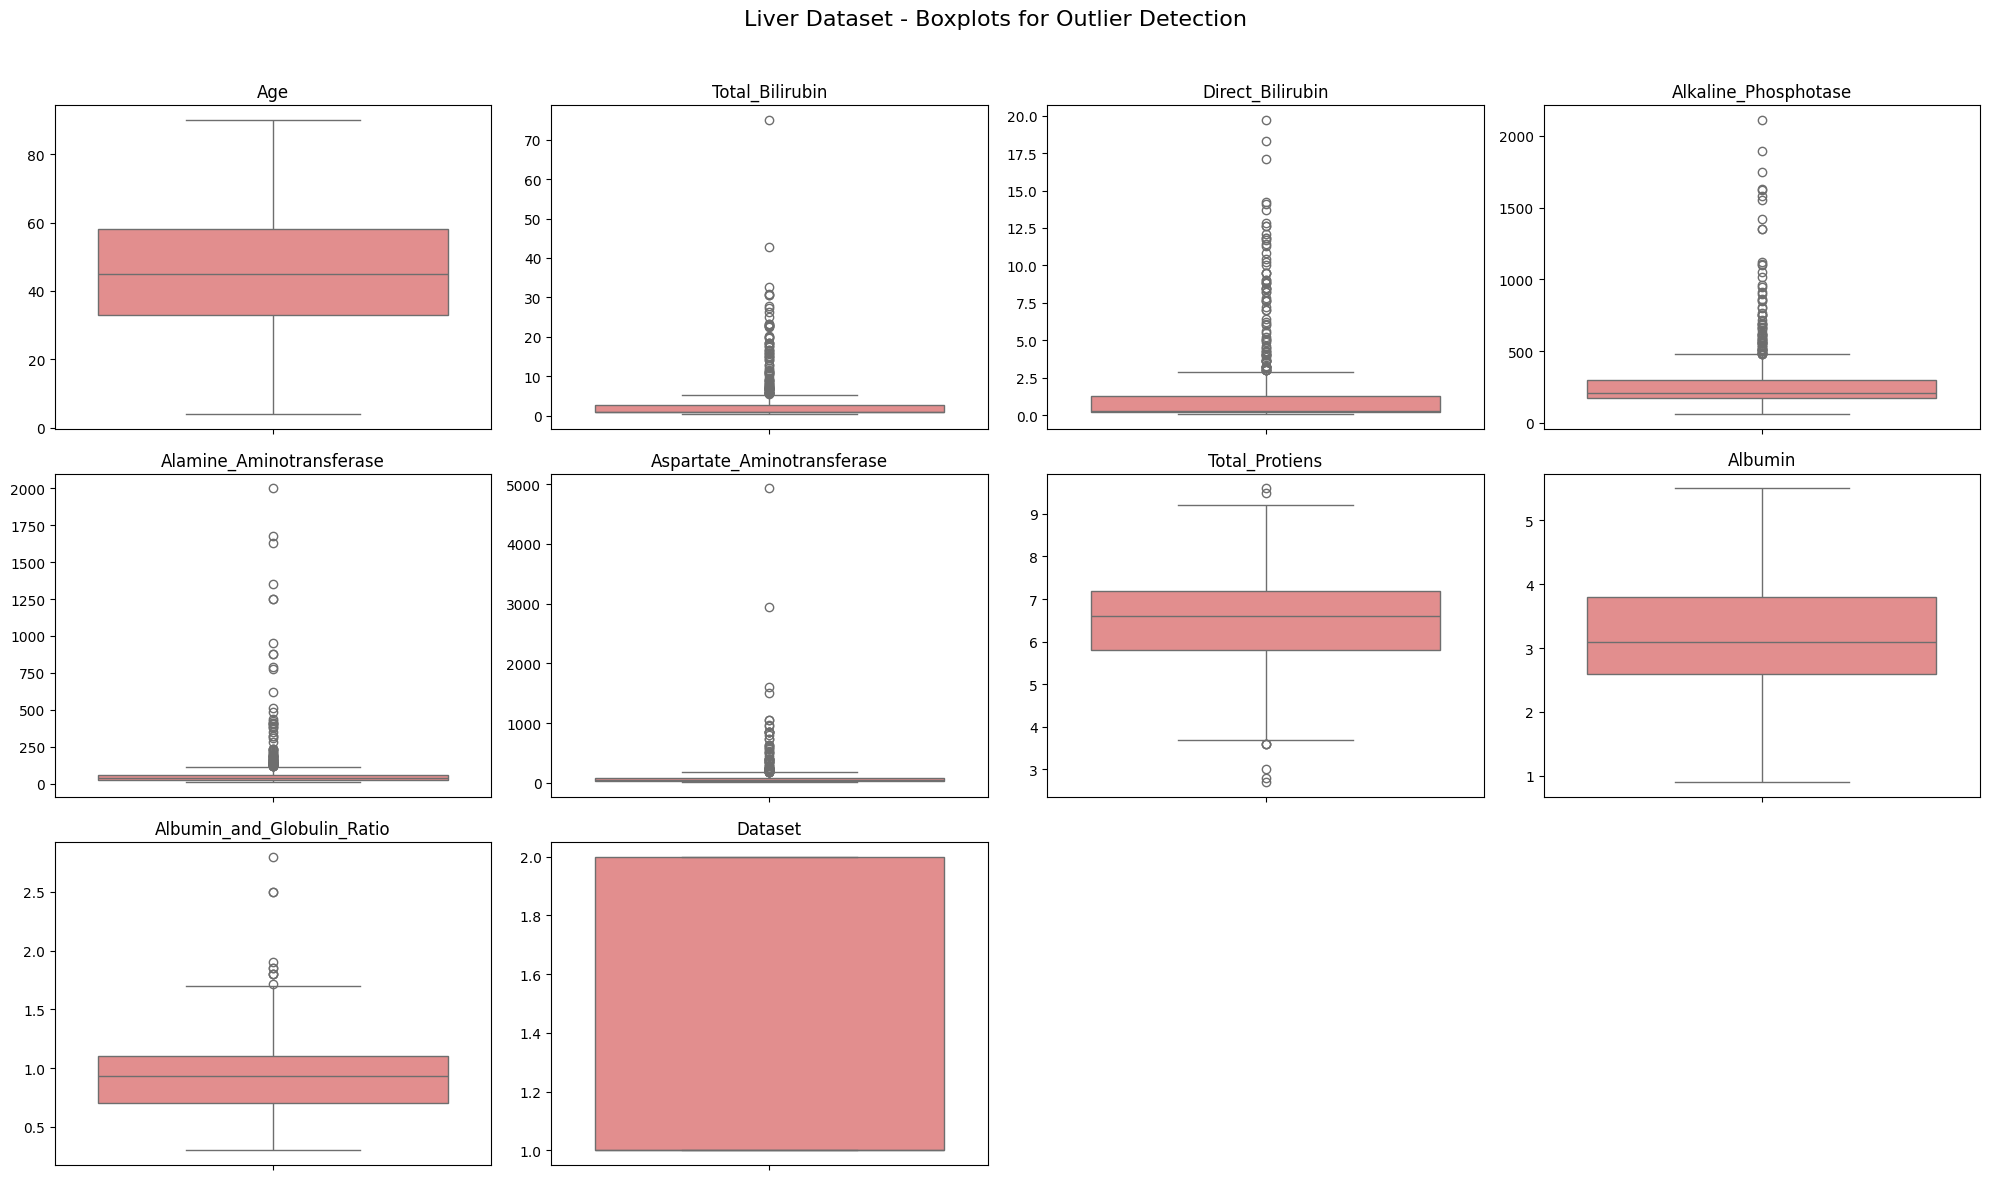

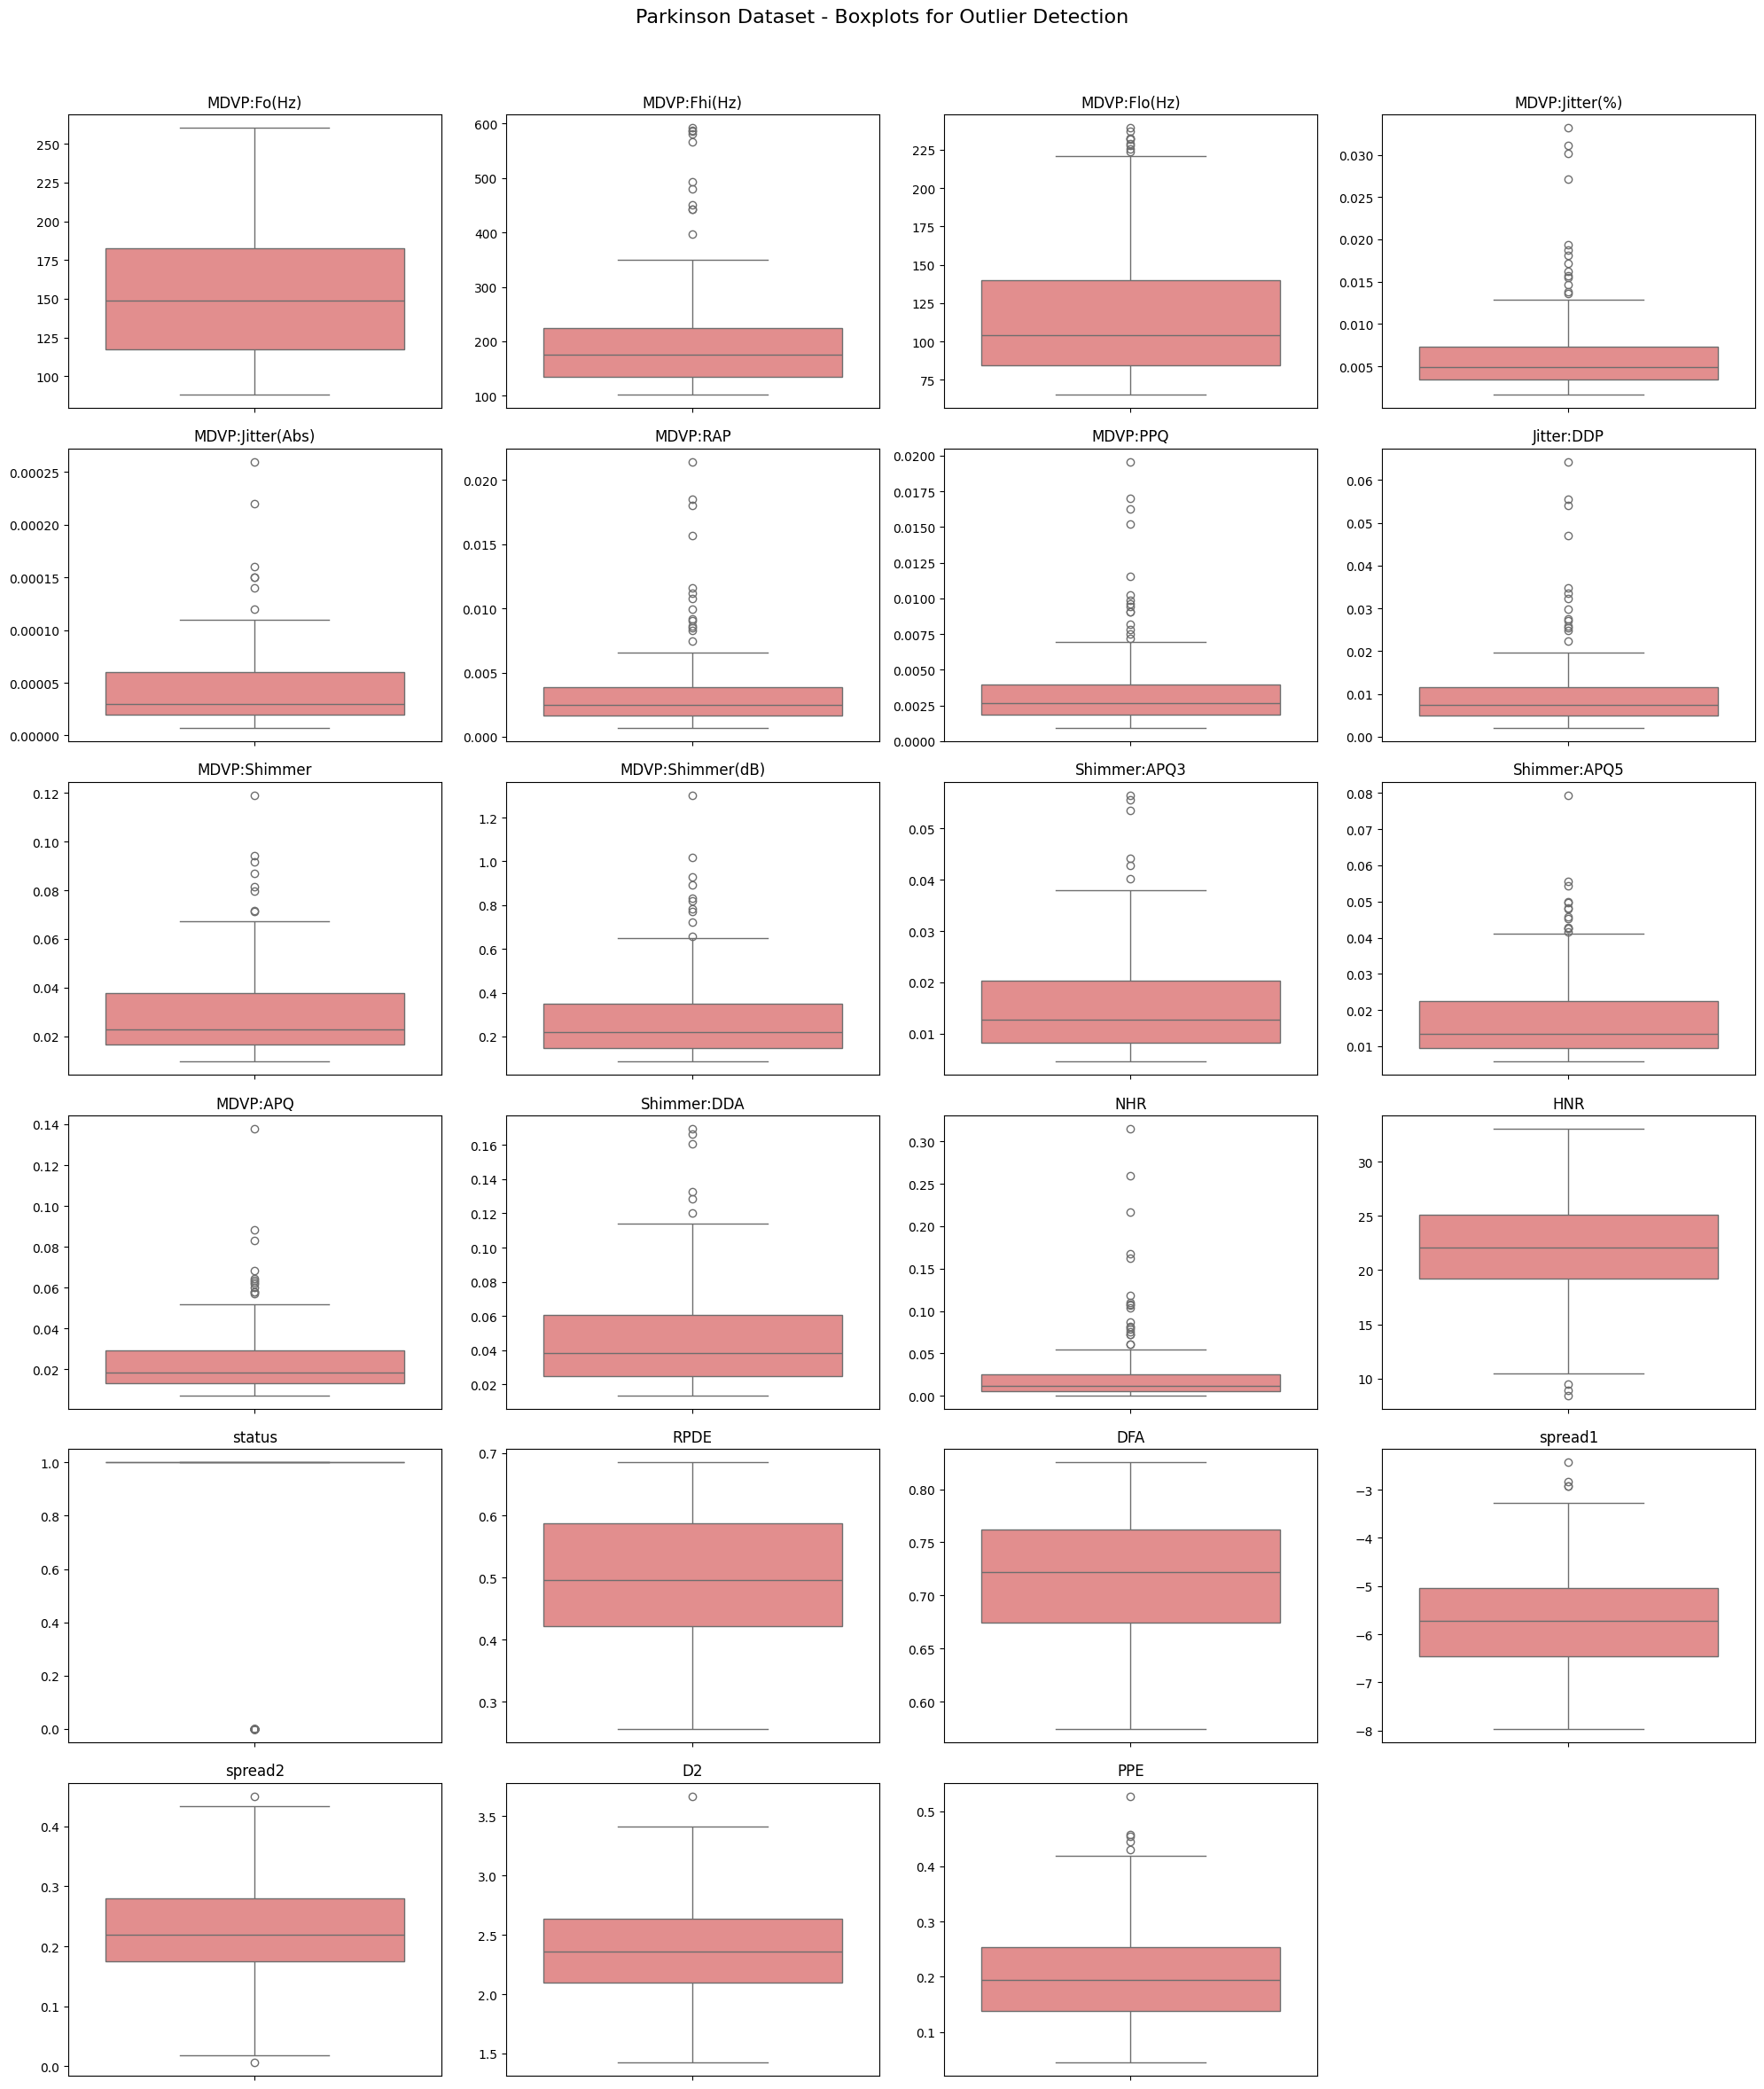

In [7]:
def plot_boxplots(df, title, cols_per_row=4):
    """
    Plot boxplots for all numeric columns in a dataframe
    to visually inspect outliers.
    """
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    n_cols = cols_per_row
    n_rows = (len(num_cols) + n_cols - 1) // n_cols  # ceil division

    plt.figure(figsize=(5*n_cols, 4*n_rows))

    for i, col in enumerate(num_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.boxplot(y=df[col], color='lightcoral')
        plt.title(col)
        plt.xlabel('')
        plt.ylabel('')

    plt.suptitle(f"{title} - Boxplots for Outlier Detection", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# ---- Apply to all datasets ----
plot_boxplots(kidney_dis, "Kidney Dataset")
plot_boxplots(liver_dis, "Liver Dataset")
plot_boxplots(parkinson_dis, "Parkinson Dataset")


#  HANDLE OUTLIERS (IQR)

In [8]:
def numeric_cols_for_iqr(df, exclude_targets=None, min_unique=3):
    exclude_targets = exclude_targets or []
    cols = df.select_dtypes(include=[np.number]).columns.tolist()
    safe_cols = [
        c for c in cols
        if c not in exclude_targets and df[c].nunique(dropna=False) >= min_unique
    ]
    return safe_cols

# For liver: exclude the target 'Dataset' and any binary columns (Gender if binary)
# liver_numeric_safe = numeric_cols_for_iqr(liver_dis, exclude_targets=['Dataset'], min_unique=3)
# For kidney: exclude target 'classification' and low-unique cols
kidney_numeric_safe = numeric_cols_for_iqr(kidney_dis, exclude_targets=['classification'], min_unique=3)
# For parkinson: exclude target 'status'
parkinson_numeric_safe = numeric_cols_for_iqr(parkinson_dis, exclude_targets=['status'], min_unique=3)




#  FEATURE / TARGET

In [9]:

# Liver
X_liver = liver_dis.drop(columns=['Dataset'])
y_liver = liver_dis['Dataset']

# Kidney (remove non-numeric or redundant columns)
X_kidney = kidney_dis.drop(columns=['classification', 'sg', 'rc', 'al', 'su'])
y_kidney = kidney_dis['classification']

# Parkinson
X_parkinson = parkinson_dis.drop(columns=['status'])
y_parkinson = parkinson_dis['status']


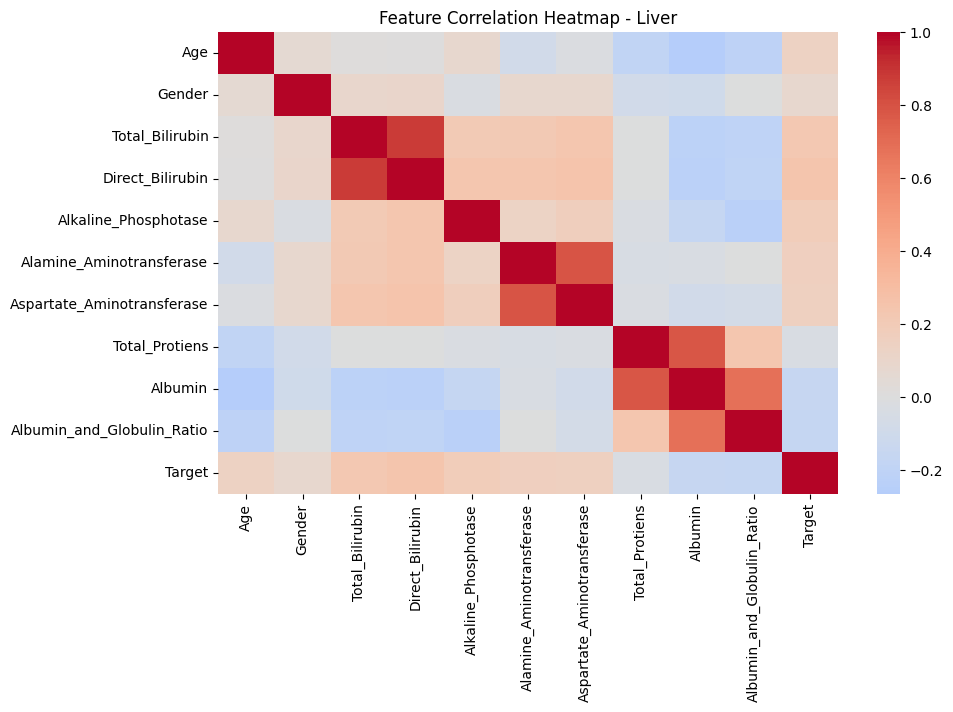

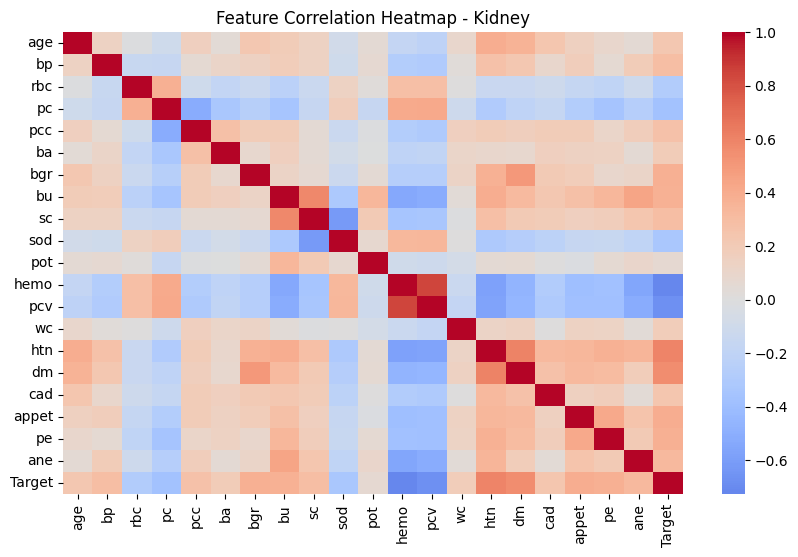

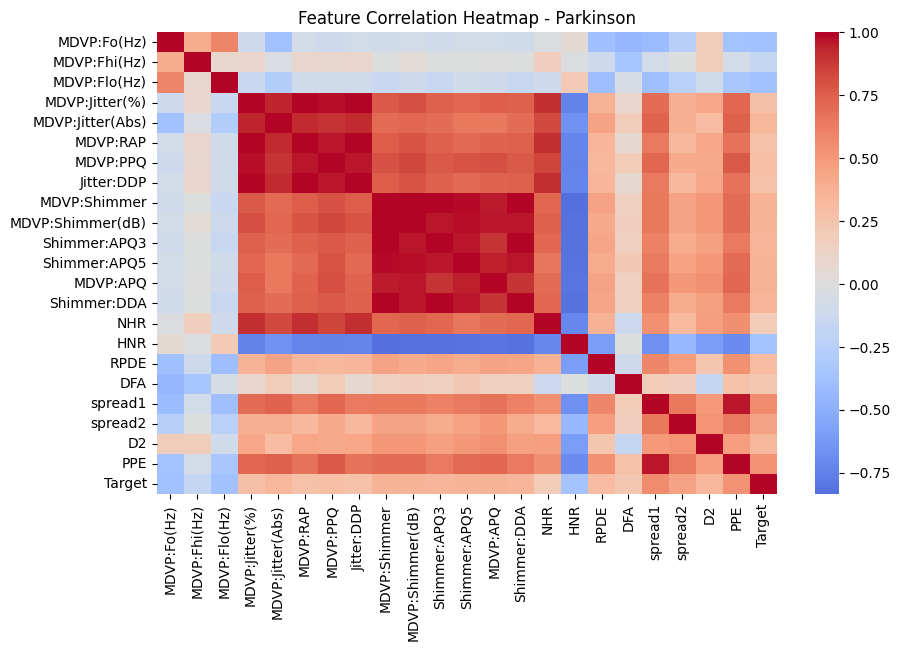

In [38]:

def plot_feature_heatmap(X, y, title):
    df = pd.DataFrame(X, columns=X.columns if isinstance(X, pd.DataFrame) else range(X.shape[1]))
    df['Target'] = y.values if isinstance(y, pd.Series) else y
    corr = df.corr()
    plt.figure(figsize=(10,6))
    sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
    plt.title(f"Feature Correlation Heatmap - {title}")
    plt.show()

def plot_corr_importance(df, target, title):
    corr = df.corr()[target].drop(target)
    corr_abs = corr.abs().sort_values(ascending=True)
    plt.figure(figsize=(10,6))
    corr_abs.plot(kind='barh', color='red')
    plt.title(f"Feature Importance (Correlation with {target}) - {title}")
    plt.xlabel("Absolute Correlation")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

plot_feature_heatmap(X_liver, y_liver, "Liver")
plot_feature_heatmap(X_kidney, y_kidney, "Kidney")
plot_feature_heatmap(X_parkinson, y_parkinson, "Parkinson")




# FEATURE IMPORTANCE / CORRELATION

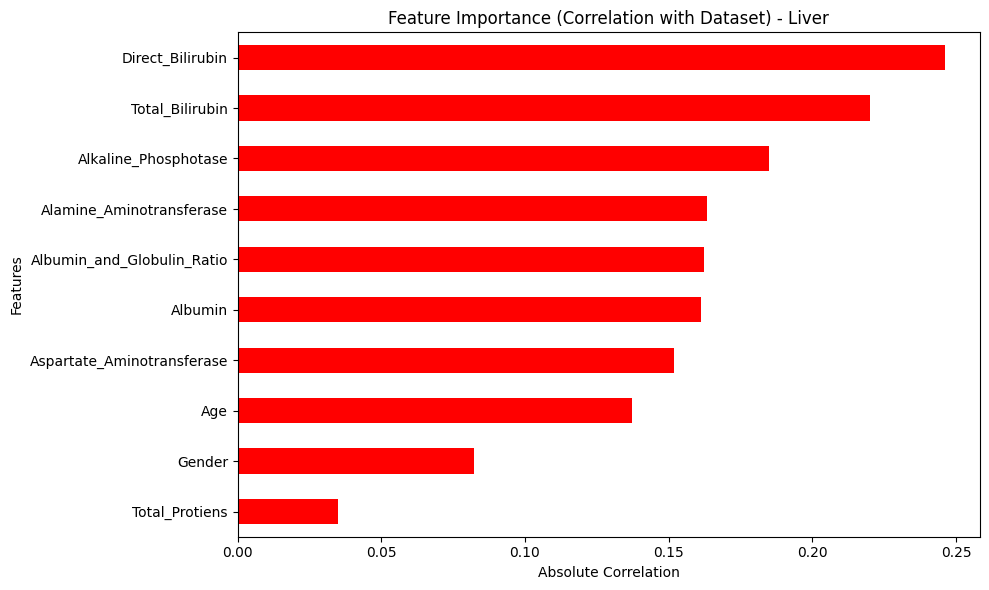

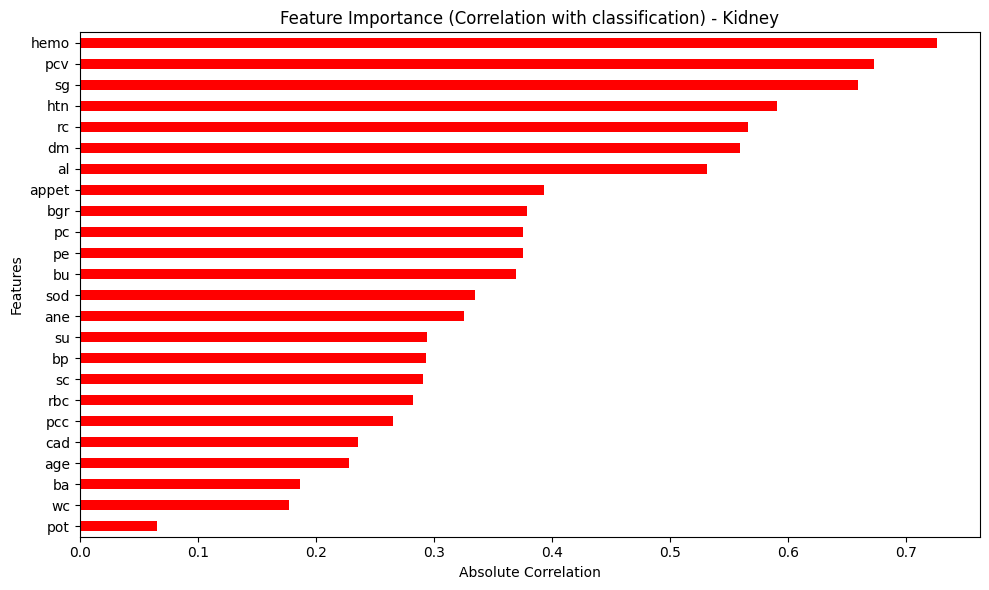

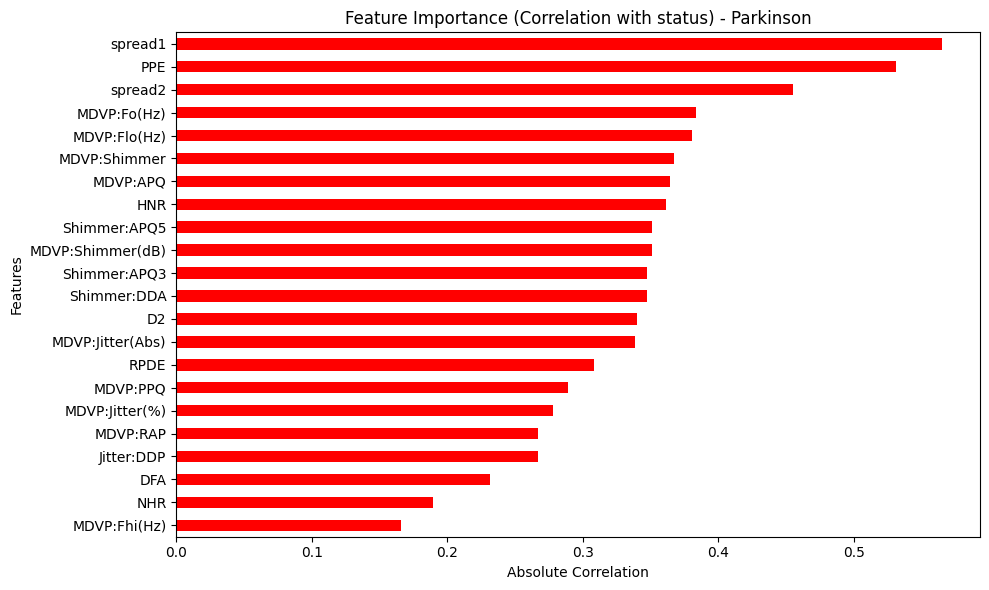

In [39]:
plot_corr_importance(liver_dis, 'Dataset', "Liver")
plot_corr_importance(kidney_dis, 'classification', "Kidney")
plot_corr_importance(parkinson_dis, 'status', "Parkinson")


#  BALANCING & SCALING

In [ ]:

scaler = StandardScaler()
smote = SMOTE(random_state=42)

def prepare_data(X, y, dataset_name, test_size=0.2):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    print(f"\n🔹 Before SMOTE ({dataset_name}):")
    print(pd.Series(y_train).value_counts())

    # Apply SMOTE
    X_train, y_train = smote.fit_resample(X_train, y_train)

    print(f"\n After SMOTE ({dataset_name}):")
    print(pd.Series(y_train).value_counts())

    # Scale numeric features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


# ==============================
# 🔹 Apply to All Datasets
# ==============================
X_train_liver, X_test_liver, y_train_liver, y_test_liver = prepare_data(X_liver, y_liver, "Liver")
X_train_kidney, X_test_kidney, y_train_kidney, y_test_kidney = prepare_data(X_kidney, y_kidney, "Kidney")
X_train_parkinson, X_test_parkinson, y_train_parkinson, y_test_parkinson = prepare_data(X_parkinson, y_parkinson, "Parkinson")


🔹 Before SMOTE (Liver):
Dataset
1    333
0    133
Name: count, dtype: int64

 After SMOTE (Liver):
Dataset
1    333
0    333
Name: count, dtype: int64

🔹 Before SMOTE (Kidney):
classification
1    200
0    120
Name: count, dtype: int64

 After SMOTE (Kidney):
classification
1    200
0    200
Name: count, dtype: int64

🔹 Before SMOTE (Parkinson):
status
1    118
0     38
Name: count, dtype: int64

 After SMOTE (Parkinson):
status
0    118
1    118
Name: count, dtype: int64


#  MODEL TRAINING & EVALUATION


In [ ]:

def evaluate_basic_models(X_train, X_test, y_train, y_test, dataset_name):
    print(f"\n==============================")
    print(f"📊 Basic Model Evaluation for {dataset_name} Dataset")
    print(f"==============================")

    models = {
        "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced"),
        "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
        "SVM": SVC(probability=True, class_weight="balanced", random_state=42),
        "KNN": KNeighborsClassifier(),
        "Gradient Boosting": GradientBoostingClassifier(random_state=42),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "Naive Bayes": GaussianNB(),
    }

    results = {}

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_proba)

        results[name] = {"Accuracy": acc, "AUC": auc}

        print(f"\n{name}:")
        print(f"Accuracy: {acc:.3f}")
        print(f"AUC: {auc:.3f}")
        print(classification_report(y_test, y_pred, zero_division=0))

    return results

#  RESULTS FOR ALL DATASETS

In [73]:

basic_parkinson_results = evaluate_basic_models(X_train_parkinson, X_test_parkinson, y_train_parkinson, y_test_parkinson, "Parkinson")



📊 Basic Model Evaluation for Parkinson Dataset

Logistic Regression:
Accuracy: 0.795
AUC: 0.924
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.96      0.76      0.85        29

    accuracy                           0.79        39
   macro avg       0.76      0.83      0.77        39
weighted avg       0.86      0.79      0.81        39


Random Forest:
Accuracy: 0.897
AUC: 0.984
              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.96      0.90      0.93        29

    accuracy                           0.90        39
   macro avg       0.86      0.90      0.87        39
weighted avg       0.91      0.90      0.90        39


Decision Tree:
Accuracy: 0.795
AUC: 0.731
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        10
           1       0.86      0.86      0.86        29


C:\Users\rajul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:40:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [74]:
basic_kidney_results = evaluate_basic_models(X_train_kidney, X_test_kidney, y_train_kidney, y_test_kidney, "Kidney")


📊 Basic Model Evaluation for Kidney Dataset

Logistic Regression:
Accuracy: 0.950
AUC: 0.982
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        30
           1       1.00      0.92      0.96        50

    accuracy                           0.95        80
   macro avg       0.94      0.96      0.95        80
weighted avg       0.96      0.95      0.95        80


Random Forest:
Accuracy: 0.963
AUC: 0.998
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.98      0.96      0.97        50

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80


Decision Tree:
Accuracy: 0.963
AUC: 0.970
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        30
           1       1.00      0.94      0.97        50

  

C:\Users\rajul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:40:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [75]:
basic_liver_results = evaluate_basic_models(X_train_liver, X_test_liver, y_train_liver, y_test_liver, "Liver")


📊 Basic Model Evaluation for Liver Dataset

Logistic Regression:
Accuracy: 0.735
AUC: 0.819
              precision    recall  f1-score   support

           0       0.53      0.82      0.64        34
           1       0.91      0.70      0.79        83

    accuracy                           0.74       117
   macro avg       0.72      0.76      0.72       117
weighted avg       0.80      0.74      0.75       117


Random Forest:
Accuracy: 0.675
AUC: 0.774
              precision    recall  f1-score   support

           0       0.42      0.32      0.37        34
           1       0.75      0.82      0.78        83

    accuracy                           0.68       117
   macro avg       0.59      0.57      0.57       117
weighted avg       0.65      0.68      0.66       117


Decision Tree:
Accuracy: 0.632
AUC: 0.559
              precision    recall  f1-score   support

           0       0.37      0.38      0.38        34
           1       0.74      0.73      0.74        83

   

C:\Users\rajul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:40:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# Hyperparameter Tuning for all models

In [ ]:
# ==============================
# 🔍 HYPERPARAMETER TUNING
# ==============================

from sklearn.model_selection import GridSearchCV

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, class_weight="balanced", random_state=42),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

param_grids = {
    "LogisticRegression": {"C": [0.01, 0.1, 1, 10, 100]},
    "RandomForest": {"n_estimators": [50,100,150], "max_depth": [4,6,8,None]},
    "DecisionTree": {"max_depth": [4,6,8,None]},
    "GradientBoosting": {"n_estimators":[50,100], "learning_rate":[0.01,0.1,0.2]},
    "SVM": {"C":[0.1,1,10], "kernel":["linear","rbf"]},
    "KNN": {"n_neighbors":[3,5,7,9], "weights":["uniform","distance"]},
    "NaiveBayes": {},
    "XGBoost": {"n_estimators":[50,100], "learning_rate":[0.01,0.1,0.2], "max_depth":[3,5,7]}
}

def hypertune_models(X_train, y_train, X_test, y_test, dataset_name):
    print(f"\n==============================")
    print(f"🔧 Hyperparameter Tuning for {dataset_name} Dataset")
    print(f"==============================")

    best_models = {}

    for name, model in models.items():
        params = param_grids.get(name, {})
        print(f"\n▶️ Tuning {name}...")

        if not params:
            print(f"⚠️ {name} has no parameters to tune. Using default model.")
            model.fit(X_train, y_train)
            best_model = model
        else:
            grid = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            print(f" Best Parameters for {name}: {grid.best_params_}")

        best_models[name] = best_model

        # Evaluation
        y_pred = best_model.predict(X_test)
        if hasattr(best_model, "predict_proba"):
            y_proba = best_model.predict_proba(X_test)[:, 1]
        else:
            y_proba = best_model.decision_function(X_test)

        print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
        print(f"AUC: {roc_auc_score(y_test, y_proba):.3f}")
        print(classification_report(y_test, y_pred, zero_division=0))

    return best_models



In [78]:

# ==============================
#  Apply to Parkinson and Liver datasets
# ==============================
best_models_liver = hypertune_models(X_train_liver, y_train_liver, X_test_liver, y_test_liver, "Liver")
best_models_kidney = hypertune_models(X_train_kidney, y_train_kidney, X_test_kidney, y_test_kidney, "Kidney")
best_models_parkinson = hypertune_models(X_train_parkinson, y_train_parkinson, X_test_parkinson, y_test_parkinson, "Parkinson")


🔧 Hyperparameter Tuning for Liver Dataset

▶️ Tuning LogisticRegression...
 Best Parameters for LogisticRegression: {'C': 100}
Accuracy: 0.735
AUC: 0.811
              precision    recall  f1-score   support

           0       0.53      0.82      0.64        34
           1       0.91      0.70      0.79        83

    accuracy                           0.74       117
   macro avg       0.72      0.76      0.72       117
weighted avg       0.80      0.74      0.75       117


▶️ Tuning RandomForest...
 Best Parameters for RandomForest: {'max_depth': None, 'n_estimators': 150}
Accuracy: 0.675
AUC: 0.773
              precision    recall  f1-score   support

           0       0.42      0.32      0.37        34
           1       0.75      0.82      0.78        83

    accuracy                           0.68       117
   macro avg       0.59      0.57      0.57       117
weighted avg       0.65      0.68      0.66       117


▶️ Tuning DecisionTree...
 Best Parameters for DecisionTree:

C:\Users\rajul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:45:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Accuracy: 0.692
AUC: 0.731
              precision    recall  f1-score   support

           0       0.46      0.32      0.38        34
           1       0.75      0.84      0.80        83

    accuracy                           0.69       117
   macro avg       0.61      0.58      0.59       117
weighted avg       0.67      0.69      0.67       117


🔧 Hyperparameter Tuning for Kidney Dataset

▶️ Tuning LogisticRegression...
 Best Parameters for LogisticRegression: {'C': 0.1}
Accuracy: 0.938
AUC: 0.971
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        30
           1       1.00      0.90      0.95        50

    accuracy                           0.94        80
   macro avg       0.93      0.95      0.94        80
weighted avg       0.95      0.94      0.94        80


▶️ Tuning RandomForest...
 Best Parameters for RandomForest: {'max_depth

C:\Users\rajul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:45:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Accuracy: 0.963
AUC: 0.999
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        30
           1       1.00      0.94      0.97        50

    accuracy                           0.96        80
   macro avg       0.95      0.97      0.96        80
weighted avg       0.97      0.96      0.96        80


🔧 Hyperparameter Tuning for Parkinson Dataset

▶️ Tuning LogisticRegression...
 Best Parameters for LogisticRegression: {'C': 10}
Accuracy: 0.846
AUC: 0.921
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.93      0.86      0.89        29

    accuracy                           0.85        39
   macro avg       0.80      0.83      0.81        39
weighted avg       0.86      0.85      0.85        39


▶️ Tuning RandomForest...
 Best Parameters for RandomForest: {'max_dep

C:\Users\rajul\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [13:46:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
